In [1]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp, potential_temp
from isca_tools.convection.base import convection_neutral_profile
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots
from isca_tools.thesis.adiabat_theory2 import get_cape_approx
from isca_tools.thesis.lapse_integral import integral_and_error_calc
from isca_tools.thesis.lapse_integral_simple import get_temp_2_layer_approx, get_lnb_ind, parcel_fitting
from isca_tools.thesis.lapse_theory import get_var_at_plev, _get_var_at_plev
from isca_tools.thesis.mod_parcel_theory import get_scale_factor_theory_numerical, get_temp_mod_parcel
from isca_tools.utils.base import weighted_RMS, insert_to_array
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile, lcl_sigma_bolton_simple
from isca_tools.thesis.profile_fitting import get_mse_env, get_tropopause_lev_ind, get_mse_prof_rms
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
from typing import Tuple, Optional
import os
from sklearn.decomposition import PCA

from isca_tools.utils.xarray import wrap_with_apply_ufunc

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Formatting figures info
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

In [3]:
print('LCL Bolton Calc Sensitivity')
for var2 in [0.25, 0.5, 0.75]:
    for var in [290, 300, 310]:
        print(var2, var, f"{lcl_sigma_bolton_simple(var2, var):.3f}")

print('\\nu value for T=300: ', np.log(lcl_sigma_bolton_simple(var2, 300)) / np.log(var2))

LCL Bolton Calc Sensitivity
0.25 290 0.722
0.25 300 0.710
0.25 310 0.699
0.5 290 0.850
0.5 300 0.843
0.5 310 0.836
0.75 290 0.935
0.75 300 0.932
0.75 310 0.928
\nu value for T=300:  0.246581572769953


## Load Data
Once compute the parcel temperature at $p_{FT}$, I save the dataset as takes around 8 minutes to compute.

In [4]:
from jobs.theory_lapse.isca.thesis_figs.load_ds_quant import get_ds, get_P

ds = get_ds()
ds['aquaplanet'] = ds['aquaplanet'].sel(p_ft=ds['land'].p_ft)  # had two p_ft for aquaplanet

In [111]:
from jobs.theory_lapse.isca.thesis_figs.load_ds_quant import get_ds, get_P

ds_use = get_ds(['land'], ['k=1'], ['north'])['land']

In [53]:
p_integ_upper_ind = np.where(get_P(ds_plot) < float(ds_plot.p_ft))[0][-ds_plot.n_lev_above_integral]
integral_and_error_calc(ds_plot.T.values, var[-1], get_P(ds_plot).values, float(ds_plot.TREFHT), float(ds_plot.TREFHT), float(ds_plot.PREFHT),
                        float(ds_plot.T[p_integ_upper_ind]),
                        var[-1][p_integ_upper_ind], float(ds_plot.p_ft))

(-0.006776540807849707, 0.00018625973302752684)

In [52]:
integral_and_error_calc(ds_plot.T.values, var2, get_P(ds_plot).values, float(ds_plot.TREFHT), float(ds_plot.TREFHT), float(ds_plot.PREFHT),
                        float(ds_plot.T[p_integ_upper_ind]),
                        var2[p_integ_upper_ind], float(ds_plot.p_ft))

(-0.006776540807849707, 0.0003473346195332688)

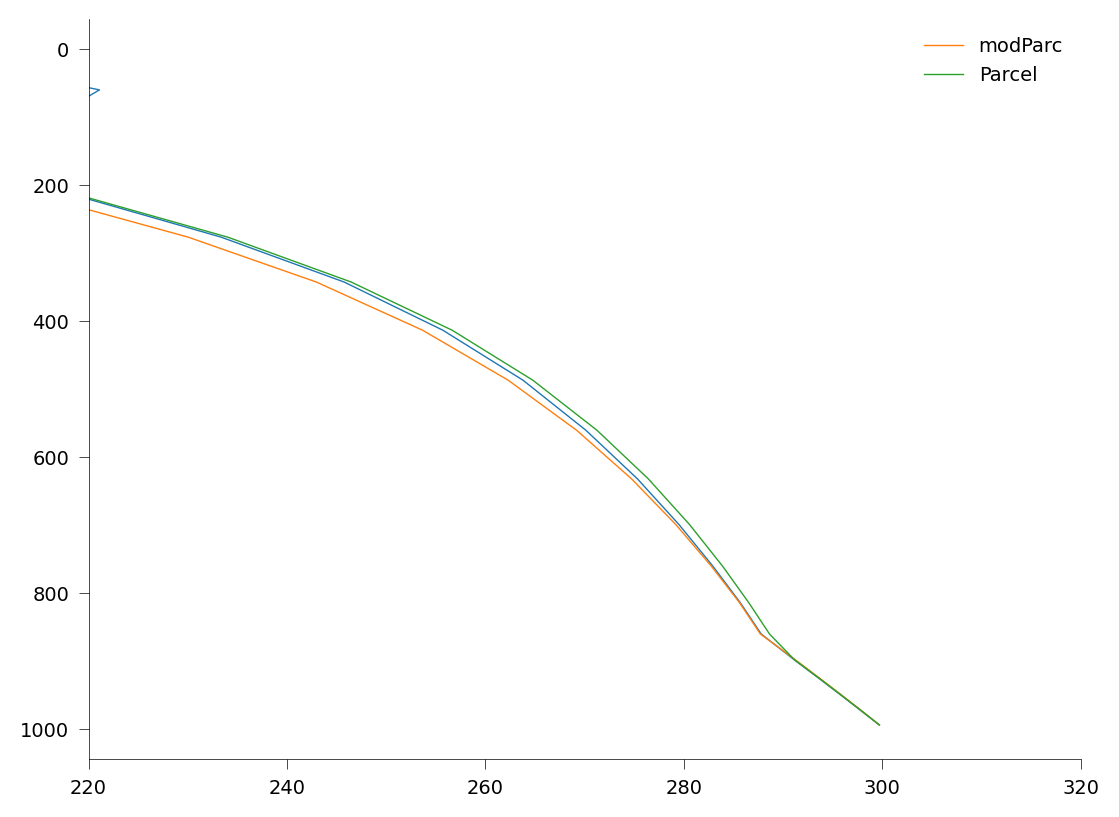

In [73]:
ds_plot = ds_use.isel(quant=-1, sample=5, lat=0)
p_lcl = lcl_sigma_bolton_simple(ds_plot.rh_REFHT, 300) * ds_plot.PREFHT
var = parcel_fitting(ds_plot.T.values, get_P(ds_plot).values, float(ds_plot.TREFHT), float(ds_plot.PREFHT),
                     float(ds_plot.rh_REFHT),
                     float(temp_lcl_env), float(p_lcl), float(ds_plot.T_ft_env),
                     float(ds_plot.p_ft), n_lev_above_upper2_integral=3, return_temp_parcel_lev=True)
key = 'mod_parcel1'
var2 = get_temp_2_layer_approx(get_P(ds_plot), float(ds_plot.TREFHT), float(ds_plot.PREFHT),
                               float(ds_plot[f"rh_REFHT"]-0.05),
                               float(ds_plot[f"{key}_lapse"].isel(layer=0)) / 1000,
                               float(ds_plot[f"{key}_lapse"].isel(layer=1)) / 1000,
                               method_layer2='mod_parcel',
                               temp_lower_lcl_calc=ds_plot.temp_surf_lcl_calc)
fig, ax = plt.subplots(1, 1)
ax.plot(ds_plot.T, get_P(ds_plot) / 100)
temp_lcl_env = get_var_at_plev(ds_plot.T, get_P(ds_plot), p_lcl, lev_dim='lev')
ax.invert_yaxis()
ax.plot(var2, get_P(ds_plot) / 100, label='modParc')
ax.plot(var[-1], get_P(ds_plot) / 100, label='Parcel')
ax.set_xlim(220, 320)
ax.legend()
plt.show()

In [65]:
lcl_sigma_bolton_simple(ds_plot.rh_REFHT-0.15, ds_plot.temp_surf_lcl_calc)

<xarray.DataArray 'rh_REFHT' ()> Size: 8B
array(0.84440616)
Coordinates:
    time     float64 8B 1.302e+03
    lon      float64 8B 0.0
    p_ft     int64 8B 50000
    lat      float64 8B 1.395
    surf     <U10 40B 'aquaplanet'
    tau_lw   int64 8B 1
    quant    int64 8B 6

In [18]:
parcel_fitting(ds_plot.T.values, get_P(ds_plot).values, float(ds_plot.TREFHT), float(ds_plot.PREFHT),
               float(ds_plot.rh_REFHT),
               float(temp_lcl_env), float(p_lcl), float(ds_plot.T_ft_env), float(ds_plot.p_ft),
               n_lev_above_upper2_integral=3, return_temp_parcel_lev=True)

(array([9.75473802, 0.        ]),
 array([-1.2113435, -5.5651973]),
 array([0.02171157, 0.19673576]),
 array([ 65.221504,  97.38956 , 115.55653 , 133.74266 , 151.80734 ,
        169.60098 , 186.96588 , 203.7182  , 219.5705  , 234.02028 ,
        246.46698 , 256.64676 , 264.7725  , 271.24493 , 276.42484 ,
        280.58185 , 283.91156 , 286.56006 , 288.6424  , 291.1482  ,
        293.9087  , 296.00293 , 297.57053 , 298.758   , 299.7165  ],
       dtype=float32))

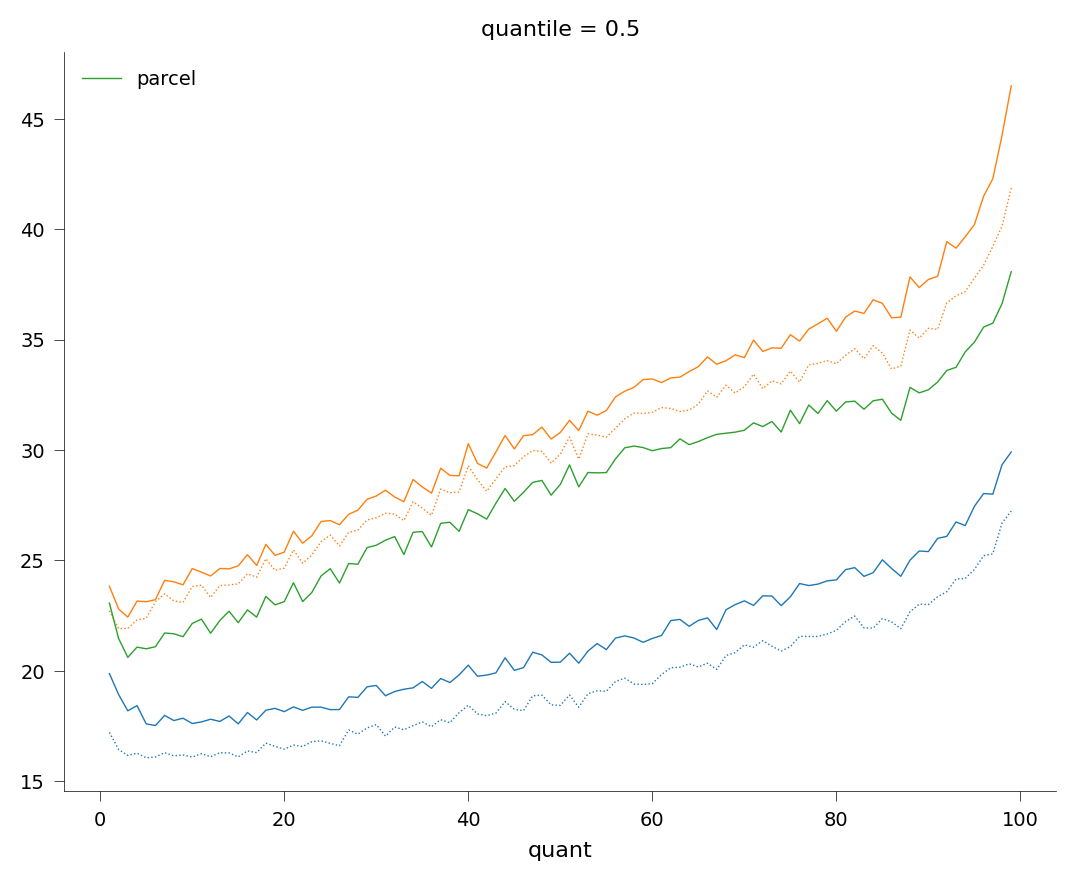

In [95]:
for j, key in enumerate(['const', 'mod_parcel', 'parcel']):
    var = area_weighting(100 * np.abs(ds_use[f"{key}1_error"] / ds_use[f"{key}1_integral"]).quantile(0.5, dim='sample')).mean(
        dim='lat').sum(dim='layer')
    if key != 'parcel':
        var.isel(rh_mod=2).plot(color=f"C{j}")
        var.isel(rh_mod=var.argmin(dim='rh_mod')).plot(color=f"C{j}", linestyle=':')
    else:
        var.plot(label=key, color=f"C{j}")
plt.gca().legend()
plt.show()

In [29]:
def get_parc_prof_error(temp_env_lev, hybm, temp_surf, p_surf, rh_surf, p_ft=500 * 100, temp_surf_lcl_calc=300,
                        n_lev_above_integral=3):
    # Returns the integral and error associated with the perfect parcel profile approximation
    p_lev = p_surf * hybm
    ind_upper = np.where(p_lev < p_ft)[0][-n_lev_above_integral]
    temp_approx_lev = get_temp_2_layer_approx(p_lev, temp_surf, p_surf, rh_surf, lapse_dry,
                                              0, 'const', 'mod_parcel',
                                              temp_lower_lcl_calc=temp_surf_lcl_calc)
    return integral_and_error_calc(temp_env_lev, temp_approx_lev, p_lev, temp_surf, temp_surf, p_surf,
                                   temp_env_lev[ind_upper], temp_approx_lev[ind_upper], p_lev[ind_upper])


get_parc_prof_error_xr = wrap_with_apply_ufunc(get_parc_prof_error,
                                               input_core_dims=[['lev'], ['lev'], [], [], []],
                                               output_core_dims=[[], []])
ds_use = ds['aquaplanet'].isel(sample=slice(0, 5), tau_lw=0)
get_parc_prof_error_xr(ds_use.T, ds_use.hybm, ds_use.TREFHT, ds_use.PREFHT, ds_use.rh_REFHT)

(<xarray.DataArray (quant: 99, lat: 14, sample: 5)> Size: 55kB
 array([[[-0.0060018 , -0.00611845, -0.00643946, -0.00629927,
          -0.00593036],
         [-0.00622704, -0.00631279, -0.00622263, -0.00635823,
          -0.00621461],
         [-0.00700717, -0.00681512, -0.00665653, -0.00650897,
          -0.00686345],
         ...,
         [-0.0060783 , -0.00618676, -0.00671794, -0.00681634,
          -0.00610493],
         [-0.00587071, -0.00585978, -0.00614749, -0.00607656,
          -0.00592449],
         [-0.00614974, -0.00606707, -0.00554822, -0.00590841,
          -0.00582611]],
 
        [[-0.00608426, -0.00623981, -0.0062287 , -0.00610087,
          -0.00663458],
         [-0.0058856 , -0.00646776, -0.00647885, -0.00630527,
          -0.00618944],
         [-0.00693817, -0.00630476, -0.00691301, -0.00668885,
          -0.00691824],
 ...
         [-0.00673489, -0.00685217, -0.00679008, -0.00666415,
          -0.0067333 ],
         [-0.00672206, -0.00670026, -0.00659158, -0.006

### LZB pressure
Compute the pressure of level of neutral buoyancy, as have an idea of height convection reaches.

## Example Days
#### Aquaplanet
Below I show example days to indicate why simple CAPE increases so much for the coldest days.
This also introduces `mod_parcel` framework, and shows two days where it is better than `const_lapse`.

#### Land
This is to show an example day which is undergoing shallow convection, and `const_lapse` is better than `modParc`, so non-convective day.

Kappa = 1.0 | Lat = 18.1 | x=1
Convflag: 2.0
Epsilon: -7299 J/kg
sCAPE: -426.5 J/kg
const params: D=-0.44 K/km | M=4.83 K/km | Error = 18.3%
modParc params: D=-0.44 K/km | M=-0.85 K/km | Error = 9.8%
T_parcel error: 22.2%
Model output CAPE: 36.6 J/kg
Kappa = 1.5 | Lat = 18.1 | x=1
Convflag: 2.0
Epsilon: -1054 J/kg
sCAPE: -46.3 J/kg
const params: D=-1.44 K/km | M=4.67 K/km | Error = 15.1%
modParc params: D=-1.44 K/km | M=0.09 K/km | Error = 12.2%
T_parcel error: 13.9%
Model output CAPE: 78.9 J/kg


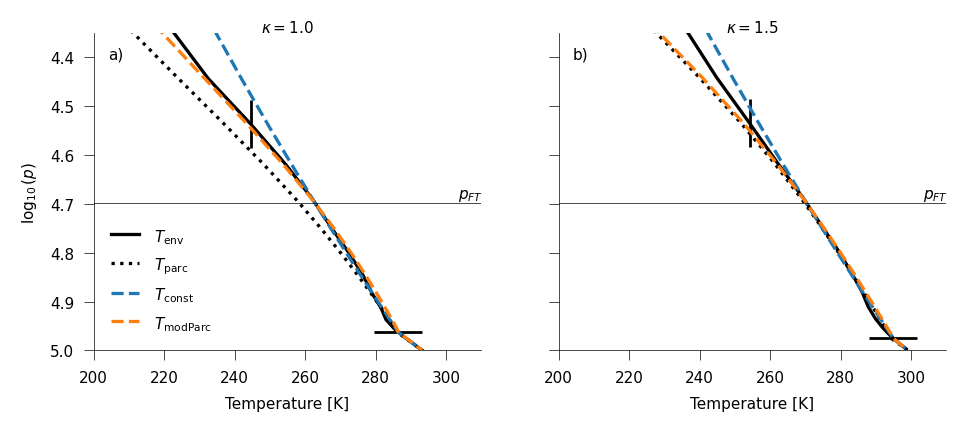

In [7]:
lat_plot = 18
surf_plot = 'aquaplanet'
sample_plot_ind = {'aquaplanet': [79, 64],
                   'land': [6, 21]}  # Good examples with convflag = 2 and lower mod_parcel error
# sample_plot_ind = [6, 21] # Good examples with convflag = 2 and lower mod_parcel error
quant_plot = 0
show_lcl_markers = True
leg_handlelength = 1.4

fig, ax = plt.subplots(1, ds['aquaplanet'].tau_lw.size, sharey=True, sharex=True)
fig_resize(fig, width['two_col'])
for j in range(ds['aquaplanet'].tau_lw.size):
    ds_plot = ds[surf_plot].sel(lat=lat_plot, method='nearest').isel(tau_lw=j).sel(quant=quant_plot, method='nearest')
    # ds_plot = ds_plot.mean(dim='sample')
    # ds_plot.attrs = ds['land'].attrs
    # print(np.where((ds_plot.convflag>=2) & (ds_plot.mod_parcel1_error.sum(dim='layer') < ds_plot.const1_error.sum(dim='layer')))[0][[1, 6][j]])   # how I got sample inds for aquaplanet
    # print(np.where((ds_plot.convflag<=1) & (ds_plot.mod_parcel1_error.sum(dim='layer') > ds_plot.const1_error.sum(dim='layer')) &
    #                (np.abs(ds_plot.mod_parcel1_error.sum(dim='layer')/ds_plot.mod_parcel1_integral.sum(dim='layer'))>0.25))[0])   # how I got sample inds for land
    ds_plot = ds_plot.isel(sample=sample_plot_ind[surf_plot][j])

    ds_plot['lnb_ind'] = get_tropopause_lev_ind(ds_plot.T, ds_plot.Z3, get_P(ds_plot))
    p_thresh = float(get_P(ds_plot).isel(lev=ds_plot.lnb_ind) - 1)
    p_thresh = 0

    ds_plot['p_lcl'] = lcl_sigma_bolton_simple(ds_plot.rh_REFHT, ds_plot.temp_surf_lcl_calc) * ds_plot.PREFHT
    ds_plot['T_lcl_env'] = get_var_at_plev(ds_plot.T, get_P(ds_plot), ds_plot.p_lcl)

    p_use, temp_env_use = insert_to_array(get_P(ds_plot).to_numpy(), ds_plot.T.to_numpy(),
                                          [float(ds_plot.p_lcl), ds_plot.p_ft],
                                          [float(ds_plot.T_lcl_env), float(ds_plot.T_ft_env)])
    use_lev = p_use >= p_thresh
    ax[j].plot(temp_env_use[use_lev], np.log10(p_use)[use_lev], color='k',
               label='$T_{\\text{env}}$' if j == 0 else None)

    T_parcel_use = get_temp_2_layer_approx(p_use, float(ds_plot.TREFHT), float(ds_plot.PREFHT),
                                           float(ds_plot.rh_REFHT),
                                           lapse_dry, 0,
                                           method_layer2='mod_parcel', temp_lower_lcl_calc=ds_plot.temp_surf_lcl_calc)
    ax[j].plot(T_parcel_use[use_lev], np.log10(p_use)[use_lev], color='k', linestyle=':',
               label='$T_{\\text{parc}}$' if j == 0 else None)

    line_leg2 = []
    line_leg2_label = []
    for i, key in enumerate(['const1', 'modParc1']):
        temp_approx_use = get_temp_2_layer_approx(p_use, float(ds_plot.TREFHT), float(ds_plot.PREFHT),
                                                  float(ds_plot[f"rh_REFHT"]),
                                                  float(ds_plot[f"{key}_lapse"].isel(layer=0)) / 1000,
                                                  float(ds_plot[f"{key}_lapse"].isel(layer=1)) / 1000,
                                                  method_layer2=key.replace('1', '').replace('Parc', '_parcel'),
                                                  temp_lower_lcl_calc=ds_plot.temp_surf_lcl_calc)
        label_m = '$\eta_M' if i == 1 else '$\Gamma_{AL\mathrm{bulk}}'
        # label_use = (f"$\eta_{'{D}'} = {ds_plot[f'{key}_lapse'].isel(layer=0) - lapse_dry * 1000:.2f}$ K/km\n"
        #              f"{label_m} = {ds_plot[f'{key}_lapse'].isel(layer=1):.2f}$ K/km")
        label_use = "$T_{\\text{" + key[:-1] + "}}$" if j == 0 else None
        line, = ax[j].plot(temp_approx_use[use_lev], np.log10(p_use)[use_lev], color=f'C{i}',
                           label=label_use, linestyle='--')
        line_leg2.append(line)
        label_use = f'{key[:-1]}: {np.abs(np.sum(ds_plot[f"{key}_error"]) / np.sum(ds_plot[f"{key}_integral"]) * 100):.0f}%'
        line_leg2_label.append(label_use)

    if show_lcl_markers:
        ax[j].scatter(ds_plot.T_lcl_env, np.log10(ds_plot.p_lcl), marker='_', s=300, color='k', lw=1)
        p_integ_upper_ind = np.where(p_use < float(ds_plot.p_ft))[0][-ds_plot.n_lev_above_integral]
        ax[j].scatter(ds_plot.T[p_integ_upper_ind], np.log10(p_use[p_integ_upper_ind]), color='k', marker='|', s=300,
                      lw=1)
    update_linewidth(fig, 1.5)
    # Legend 2 (e.g., model meaning)
    leg2 = ax[j].legend(
        handles=line_leg2,
        labels=line_leg2_label,
        loc="upper right",
        title="Fitting Error", handlelength=leg_handlelength
    )
    # ax[j].add_artist(leg2)
    ax[j].legend(loc='lower left', handlelength=leg_handlelength)
    ax[j].set_title(f"$\kappa={ds_plot.tau_lw:.1f}$", y=0.95)
    # ax[j].set_title(
    #     f"$\kappa={ds_plot.tau_lw:.1f}$ | Lat = {ds_plot.lat:.1f}$\degree$ | $x={ds_plot.quant:.0f}$",
    #     fontsize=8.5)

    # Print out useful info
    print(f"Kappa = {ds_plot.tau_lw:.1f} | Lat = {ds_plot.lat:.1f} | x={ds_plot.quant:.0f}")
    print(f"Convflag: {ds_plot.convflag.values:.1f}")
    print(f"Epsilon: {(ds_plot.mse_REFHT - ds_plot.mse_ft_sat_env).values * 1000:.0f} J/kg")
    ds_plot['sCAPE'] = \
    get_cape_approx(float(ds_plot.TREFHT), float(ds_plot.rh_REFHT), float(ds_plot.PREFHT), float(ds_plot.p_ft),
                    float(ds_plot.T_ft_env),
                    float(ds_plot.mse_REFHT - ds_plot.mse_ft_sat_env))[0]
    print(f"sCAPE: {float(ds_plot.sCAPE) * 1000:.1f} J/kg")
    for key in ['const', 'modParc']:
        print(f"{key} params: D={ds_plot[f'{key}1_lapse'].isel(layer=0) - lapse_dry * 1000:.2f} K/km | "
              f"M={ds_plot[f'{key}1_lapse'].isel(layer=1):.2f} K/km | "
              f"Error = {np.abs(np.sum(ds_plot[f'{key}1_error']) / np.sum(ds_plot[f'{key}1_integral']) * 100):.1f}%")

    temp_approx_use = T_parcel_use  # comment out for sanity check that matches that saved to ds as mod_parcel1
    var = integral_and_error_calc(temp_env_use, temp_approx_use, p_use, float(ds_plot.TREFHT), float(ds_plot.TREFHT),
                                  float(ds_plot.PREFHT),
                                  float(temp_env_use[p_integ_upper_ind]), float(temp_approx_use[p_integ_upper_ind]),
                                  p_use[p_integ_upper_ind])
    print(f"T_parcel error: {np.abs(var[1] / var[0] * 100):.1f}%")
    print(f"Model output CAPE: {ds_plot.CAPE.values:.1f} J/kg")

ax[0].invert_yaxis()
# integral_and_error_calc(ds_plot.T, temp_approx_use, get_P(ds_plot), ds_plot.TREFHT, ds_plot.TREFHT, ds_plot.PREFHT,
#                         ds_plot.T[p_integ_upper_ind], temp_approx_use[p_integ_upper_ind], get_P(ds_plot)[p_integ_upper_ind])
ax[0].set_ylabel('$\log_{10}(p)$')
ax[0].set_xlabel('Temperature [K]')
ax[1].set_xlabel('Temperature [K]')

# update_linewidth(fig)
#
# ax[0].axhline(np.log10(ds_plot.p_ft), color='k', lw=ax_linewidth)
for i in range(2):
    ax[i].axhline(np.log10(ds_plot.p_ft), color='k', lw=ax_linewidth)
    ax[i].text(ax[i].get_xlim()[1], np.log10(ds_plot.p_ft), '$p_{FT}$', va='bottom', ha='right')

ax[0].set_ylim(5, 4.35)
ax[0].set_xlim(200, 310)
label_subplots(fig, ax)
update_fontsize(fig, 7)
plt.show()
# isca_tools.savefig(fig)

### Fitting Error
Below we show that fitting error better for `mod_parcel` for aquaplanet but not land. Also, that `convflag` closer to 2 for aquaplanet indicating deep convection triggered more.

I use median and IQR for shading because `convflag` takes almost discrete values, so $\pm$ standard deviation shading looks way too big, given
that very few days have `convflag<1`. I.e. $\pm \sigma$ forces symmetric shading, when data is not symmetric about median.

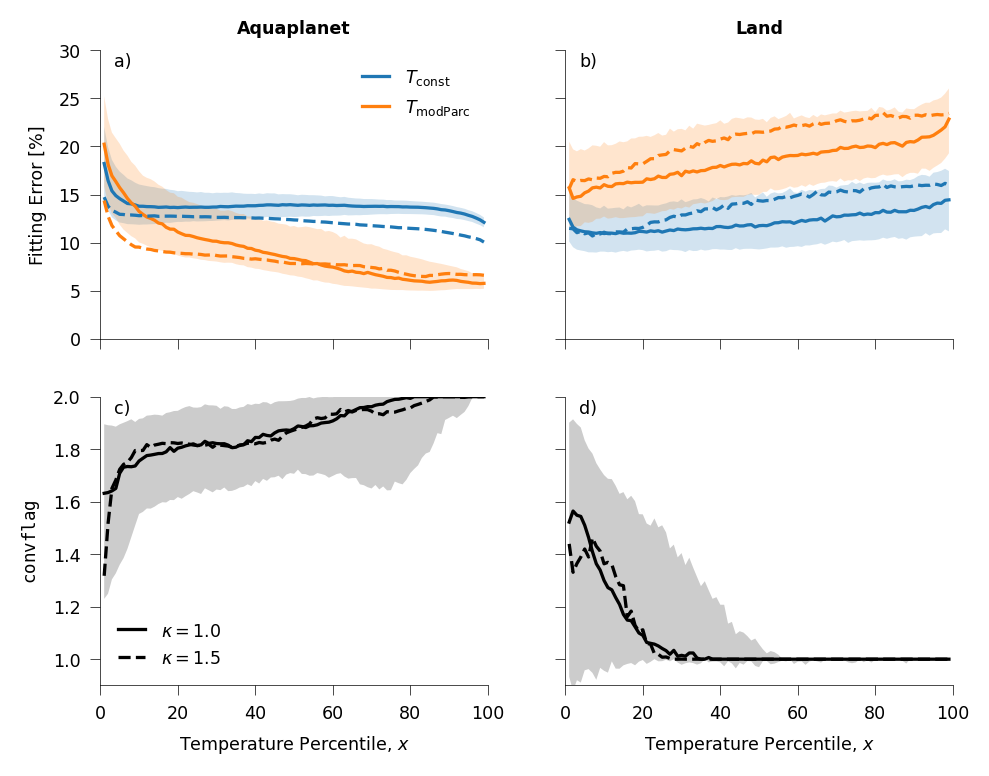

In [98]:
# lat_weights = np.cos(np.deg2rad(ds['land'].lat))
percentile_label = 'Temperature Percentile, $x$'

fig, ax = plt.subplots(2, 2, sharex=True, sharey='row')
fig_resize(fig, width['two_col'])
for k, surf_use in enumerate(ds):
    ds_use = ds[surf_use]
    lat_weights = np.cos(np.deg2rad(ds_use.lat))
    ax[0, k].set_title(surf_use.capitalize(), fontweight='bold')
    ax[1, k].set_xlabel(percentile_label)
    for j in range(ds['aquaplanet'].tau_lw.size):
        for i, key in enumerate(['const1', 'modParc1']):
            label_use = "$T_{\\text{" + key[:-1] + "}}$" if j == 0 else None
            var = np.abs(
                ds_use[f"{key}_error"].sum(dim='layer') / ds_use[f"{key}_integral"].sum(dim='layer') * 100, ).isel(
                tau_lw=j)
            ax[0, k].plot(ds_use.quant, np.average(var.quantile(0.5, dim='sample'), axis=1, weights=lat_weights),
                          color=f"C{i}",
                          linestyle=[None, '--'][j], label=label_use)
            if j == 0:
                ax[0, k].fill_between(ds_use.quant,
                                      np.average(var.quantile(0.25, dim='sample'), axis=1, weights=lat_weights),
                                      np.average(var.quantile(0.75, dim='sample'), axis=1, weights=lat_weights),
                                      alpha=0.2,
                                      color=f"C{i}", edgecolor="none")
        ax[1, k].plot(ds_use.quant, np.average(ds_use.convflag.quantile(0.5, dim='sample').isel(tau_lw=j), axis=1,
                                               weights=lat_weights),
                      color='k', linestyle=[None, '--'][j], label=f"$\kappa={ds_use.tau_lw[j]:.1f}$")
        if j == 0:
            ax[1, k].fill_between(ds_use.quant,
                                  np.average(ds_use.convflag.isel(tau_lw=j).quantile(0.25, dim='sample'), axis=1,
                                             weights=lat_weights),
                                  np.average(ds_use.convflag.isel(tau_lw=j).quantile(0.75, dim='sample'), axis=1,
                                             weights=lat_weights), alpha=0.2,
                                  color="k", edgecolor="none")

update_linewidth(fig, 1.5)
ax[0, 0].set_ylim(0, 30)
ax[1, 0].set_ylim(0.9, 2)
ax[0, 0].set_xlim(0, 100)
ax[0, 0].set_ylabel('Fitting Error [%]')
ax[1, 0].set_ylabel('$\mathtt{convflag}$')
ax[0, 0].legend(handlelength=leg_handlelength)
ax[1, 0].legend(handlelength=leg_handlelength)
label_subplots(fig, ax.flatten(), pos_y=-1, box_alpha=0)
update_fontsize(fig)
plt.show()
# isca_tools.savefig(fig)

### Valid days
Below I plot for the aquaplanet simulation, the days for which `mod_parcel` has lower error than 25% and thus days valid to consider convctive.

For land, very few days are valid so no point proceeding.

[66.33859752 80.02046347]
0.0


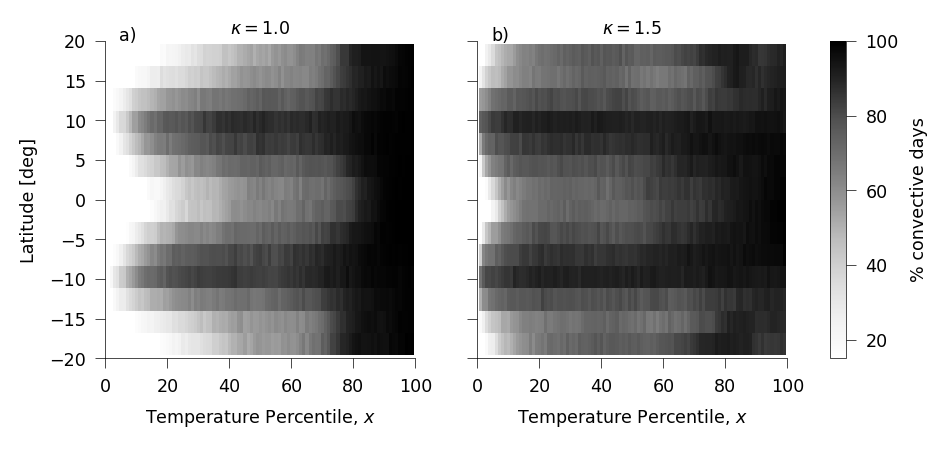

In [113]:
surf_plot = 'aquaplanet'
error_thresh = 0.25
# error_thresh2 = 0.1
const1_error = np.abs(ds[surf_plot].const1_error.sum(dim='layer') / ds[surf_plot].const1_integral.sum(dim='layer'))
mod_parcel1_error = np.abs(
    ds[surf_plot].modParc1_error.sum(dim='layer') / ds[surf_plot].modParc1_integral.sum(dim='layer'))
mask_fit = (mod_parcel1_error < const1_error) & (mod_parcel1_error < error_thresh) & (ds[surf_plot].p_lzb / 100 < 500)

# Print total number of days valid
print((mask_fit.sum(dim=['sample', 'quant', 'lat']).values / (
            mask_fit.sample.size * mask_fit.quant.size * mask_fit.lat.size)) * 100)

var = (mask_fit.sum(dim='sample') / mask_fit.sample.size * 100)
print(var.values.min())

fig, ax = plt.subplots(1, ds['aquaplanet'].tau_lw.size, sharey=True, sharex=True)
fig_resize(fig, width['two_col'])
for i in range(ds['aquaplanet'].tau_lw.size):
    im = var.T.isel(tau_lw=i).plot.imshow(ax=ax[i], cmap='Grays', vmin=15, vmax=100, add_colorbar=False)
    ax[i].set_xlabel(percentile_label)
    ax[i].set_title(f"$\kappa={var.tau_lw[i]:.1f}$", y=0.97)
ax[0].set_ylim(-20, 20)
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('Latitude [deg]')
ax[1].set_ylabel('')
fig.colorbar(im, ax=ax, label='% convective days')
label_subplots(fig, ax, box_alpha=0, pos_y=5)
update_fontsize(fig, 10)
plt.show()
# isca_tools.savefig(fig)